# Prepara el conjunto de entrenamiento 

### Descarga el conjunto de datos:
### Coloca el archivo *food-101.tar.gz* en  la misma carpeta que este notebook    

<a href="https://www.vision.ee.ethz.ch/datasets_extra/food-101/">Food-101</a>
<img src="imagenes/food101.png" alt="Food 101">



In [1]:
import numpy as np
import os
import cv2
import tarfile
import tqdm


def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def load_dataset(images,fraction):

   
    photos = []
    i= 0
    with tarfile.open(images) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
                if m.isfile() and m.name.endswith(".jpg"):
                    #prepare image
                    img = decode_image_from_raw_bytes(f.extractfile(m).read())
                    
                    #use only images of size 512x512    
                    if img.shape == (512,512,3):
                        if i % fraction == 0:
                        
                            #Resize the images to 64x64
                            resized = cv2.resize(img, (0,0), fx=0.125, fy=0.125) 
                            
                            #print("Shape of image", img.shape)
                            fname = os.path.split(m.name)[-1]
                            print("Number of Images", len(photos)+1)  
                            print("Add Image:",fname)
                            photos.extend([resized])
                        i+= 1

    
    all_photos = np.stack(photos).astype('uint8')
    
    del photos

   
    return all_photos


### Carga el conjunto de entrenamiento desde el archivo

In [ ]:
IMAGENES = "food-101.tar.gz"  # File of images

X = load_dataset(IMAGENES,fraction = 2)

In [ ]:
print("Forma de X:",X.shape)

# Guarda el conjunto de entrenamiento X como un archivo X.pyn
### Puedes gardar el conjunto de entrenamiento en un archivo .npy para cargarlo más rápido despues.

In [2]:
np.save('X.npy', X) 


NameError: name 'X' is not defined

# Carga desde el archivo X.npy

In [2]:
import numpy as np

X = np.load('X.npy')

In [3]:
print("Forma de X:",X.shape)

Forma de X: (31103, 64, 64, 3)


### Normaliza las imágenes. Cada pixel tendrá un valor entre 0 y 1

In [4]:
X = np.float32(X)/255.0

### Imágen aleatoria

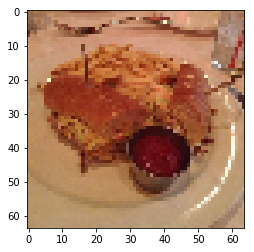

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(X[np.random.randint(X.shape[0])],cmap="gray", interpolation="none")

# Funciones auxiliares

In [8]:
from PIL import Image

def sample_noise_batch(batch_size,units ):
    return np.random.normal(size=(batch_size, units)).astype('float32')

def sample_data_batch(X,size):
    idxs = np.random.choice(np.arange(X.shape[0]), size=size)
    return X[idxs]

def show_images(images,nrow,ncol,image_shape, sharp=False):
    if np.var(images)!=0:
        images = images.clip(np.min(X),np.max(X))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(image_shape),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(image_shape),cmap="gray")
    plt.show()

def save_image(data, path):
    """
    data: numpy array 
        shape 64x64x3
    path: string
        path to save image
    save data as image in path
        
    """
    #Rescale to 0-255 and convert to uint8
    rescaled = (255.0 / data.max() * (data - data.min())).astype(np.uint8)
    
    #r = np.ceil(data*255.0).astype(np.uint8)
    im = Image.fromarray(rescaled)
    print("Save image:", path)
    im.save(path)

    
def save_batch_images(images,names ):
    """
    images: iterable
        iterable containing images 
    directory: string
        directory to save the generated images
    save all images with his respective names
    """
    assert  len(images) == len(names), "images and names must have the same length.\nLens images: {}, names: {}".format(len(images), len(names))
    
    
    for k in range(len(images)):
        save_image(images[k], names[k])
        
        

### Árticulo original GANS
<a href="https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf">Generative Adversarial Networks por Ian J. Goodfellow</a>


In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import scipy.misc
import scipy

print("Versión de tensorflow",tf.__version__)

Versión de tensorflow 1.4.0


#### Red Generadora G
Está se encarga de generar nuevas imágenes. Empieza con un vector de números aleatorios z el cual  transforma en una imágen.


In [10]:
def G(z):
    """
    z: arreglo
        vector aleatorio z
        
    """
    
    #### Capa Completamente Conectada
    z_ = slim.fully_connected(z,
                              4*4*256,
                              normalizer_fn=slim.batch_norm,
                              activation_fn=tf.nn.elu,
                              scope='g_',
                              )
    
    ### Transforma los vectores en  "volumenes"
    z_ = tf.reshape(z_,[-1,4,4,256])
    
    
    ### Convolución transpuesta
    convt1 = slim.convolution2d_transpose(z_,
                                         num_outputs=64,
                                         kernel_size=[5,5],
                                         stride=[2,2],
                                         padding="SAME",
                                         normalizer_fn=slim.batch_norm,
                                         activation_fn=tf.nn.elu,
                                         scope='g_convt1',
                                         )

    
    convt2 = slim.convolution2d_transpose(convt1,
                                         num_outputs=64,
                                         kernel_size=[5,5],
                                         stride=[2,2],                                         
                                         padding="SAME",
                                         activation_fn=tf.nn.elu,
                                         scope='g_convt2',
                                         )
    
    
    
    
   
    
    upsamp1 = tf.image.resize_images(convt2, size = (32,32))
                                 
    
    convt3 = slim.convolution2d_transpose(upsamp1, 
                                         num_outputs = 32, 
                                         stride=[2,2],
                                         kernel_size = [5,5],
                                         padding = "SAME",
                                         activation_fn=tf.nn.elu,
                                         scope='g_convt3'
                                         )
    
   
                                         
    convt4 = slim.convolution2d_transpose(convt3,
                                          num_outputs=64,
                                          kernel_size=[4,4],
                                          padding="SAME",
                                          activation_fn=tf.nn.elu,
                                          scope='g_convt5')
                                          
    convt5 = slim.convolution2d_transpose(convt4,
                                     num_outputs=64,
                                     kernel_size=[4,4],
                                     padding="SAME",
                                     activation_fn=tf.nn.elu,
                                     scope='g_convt6'
                                         )
    
    
    
    g = slim.convolution2d(convt5,
                              3,
                              [4,4],
                              padding="SAME",
                              activation_fn=tf.nn.elu,
                              scope='g_conv',
                             )
    
    return g
    
    

#### Discriminador D
Esta red recive una imágen x de 64 x 64 x 3. La red determina p(x) = probabilidad que la imagén sea "real", es decir provenga del conjunto de entrenamiento y no que sea una imágen generada por G.

In [11]:
def D(x, reuse=False):
    """
        x: arreglo
            imágen de 64x64x3
        Regresa la probabilidad de que x sea real p(x)
    """
    
    d1 = slim.convolution2d(x,
                              16,
                              kernel_size = [4,4],
                              padding="SAME",
                              activation_fn=tf.nn.elu,
                              reuse=reuse,
                              scope='d_conv1')   
    d2 = slim.convolution2d(d1,
                              32,
                              kernel_size = [4,4],
                              padding="SAME",
                              normalizer_fn=slim.batch_norm,
                              activation_fn=tf.nn.elu,
                              reuse=reuse,
                              scope='d_conv2',
                             )
    
    d3 = slim.convolution2d(d2,
                              32,
                              kernel_size = [4,4],
                              padding="SAME",
                              normalizer_fn=slim.batch_norm,
                              activation_fn=tf.nn.elu,
                              reuse=reuse,
                              scope='d_conv3',
                              )
    
    
    pool1 = slim.avg_pool2d(d3,
                           kernel_size = [2,2],
                           padding ="SAME",
                           scope = "d_pooling")

    
    d4 = slim.convolution2d(pool1,
                              64,
                              kernel_size = [3,3],
                              padding="SAME",
                              activation_fn=tf.nn.elu,
                              reuse=reuse,
                              scope='d_conv4',
                              )
    d5 = slim.convolution2d(d4,
                              64,
                              kernel_size =[3,3],
                              padding="SAME",
                              activation_fn=tf.nn.elu,
                              reuse=reuse,
                              scope='d_conv5',
                              )
    


    d_flat1 = slim.fully_connected(slim.flatten(d5),
                                 num_outputs = 512,
                                 activation_fn=tf.nn.tanh,
                                 reuse=reuse,
                                 scope='d_flat1')
    
    d = slim.fully_connected(d_flat1,
                                 num_outputs = 1,
                                 activation_fn=tf.nn.sigmoid,
                                 reuse=reuse,
                                 scope='d_out')
    
    return d

# Formando la red completa

In [12]:
with tf.device("/gpu:0"):
    
    tf.reset_default_graph()

    z_unidades = 100 #tamaño de z
    
    ### Placeholders
    
    #para z (vector aleatorio)
    z = tf.placeholder(shape=[None,z_unidades],dtype=tf.float32) 
    
    #para x (imagén generada o real)
    x = tf.placeholder(shape=[None,64,64,3],dtype=tf.float32) 

    Gz = G(z) # Genera una imágen 
    Dx = D(x, reuse= False) # La probabilidad de que x (imagén real) sea real
    Dg = D(Gz,reuse=True)  # La probabilidad de que G(z) (imagén generada) sea real
    
    #Función objetivo de la red 
    d_costo = -tf.reduce_mean(tf.log(Dx) + tf.log(1.-Dg)) #Para D. D quiere reducir p(G(z)) la probabilidad de la imágenes falsas y aumentar p(x) la prob. de las imágenes reales 
    g_costo = -tf.reduce_mean(tf.log(Dg)) #Para G. G quiere hacer pasar G(z) como una imágen real, i.e. que D le asigne una probabilidad alta.
    # G quiere engañar a D

    tvars = tf.trainable_variables()

    d_vars = [var for var in tvars if 'd_' in var.name]
    print("Variables entrenables para D", [var.name  for var in d_vars],"\n\n")
    
    g_vars = [var for var in tvars if 'g_' in var.name]
    print("Variables entrenables para G", [var.name  for var in g_vars])


    #Optimización de la red.
    trainerD = tf.train.GradientDescentOptimizer(learning_rate=1e-3)
    trainerG = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
    
    d_grads = trainerD.compute_gradients(d_costo,d_vars) 
    g_grads = trainerG.compute_gradients(g_costo,g_vars)

    act_D = trainerD.apply_gradients(d_grads)#Actualiza los parametros de D.
    act_G = trainerG.apply_gradients(g_grads)#Actualiza los parametros de G.

Variables entrenables para D ['d_conv1/weights:0', 'd_conv1/biases:0', 'd_conv2/weights:0', 'd_conv2/BatchNorm/beta:0', 'd_conv3/weights:0', 'd_conv3/BatchNorm/beta:0', 'd_conv4/weights:0', 'd_conv4/biases:0', 'd_conv5/weights:0', 'd_conv5/biases:0', 'd_flat1/weights:0', 'd_flat1/biases:0', 'd_out/weights:0', 'd_out/biases:0'] 


Variables entrenables para G ['g_/weights:0', 'g_/BatchNorm/beta:0', 'g_convt1/weights:0', 'g_convt1/BatchNorm/beta:0', 'g_convt2/weights:0', 'g_convt2/biases:0', 'g_convt3/weights:0', 'g_convt3/biases:0', 'g_convt5/weights:0', 'g_convt5/biases:0', 'g_convt6/weights:0', 'g_convt6/biases:0', 'g_conv/weights:0', 'g_conv/biases:0']


### Entrenamiento

Iteración: 0
Costo generador: 1.1776242 Costo discriminador: 0.9535233


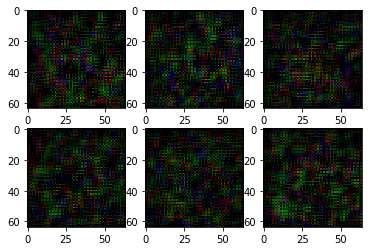

Save image: generadas/fig0.png
Save image: generadas/fig1.png
Save image: generadas/fig2.png
Save image: generadas/fig3.png
Save image: generadas/fig4.png
Save image: generadas/fig5.png
Save image: generadas/fig6.png
Save image: generadas/fig7.png
Save image: generadas/fig8.png
Save image: generadas/fig9.png
Save image: generadas/fig10.png
Save image: generadas/fig11.png
Save image: generadas/fig12.png
Save image: generadas/fig13.png
Save image: generadas/fig14.png
Save image: generadas/fig15.png
Save image: generadas/fig16.png
Save image: generadas/fig17.png
Save image: generadas/fig18.png
Save image: generadas/fig19.png
Save image: generadas/fig20.png
Save image: generadas/fig21.png
Save image: generadas/fig22.png
Save image: generadas/fig23.png
Save image: generadas/fig24.png
Save image: generadas/fig25.png
Save image: generadas/fig26.png
Save image: generadas/fig27.png
Save image: generadas/fig28.png
Save image: generadas/fig29.png
Save image: generadas/fig30.png
Save image: genera

In [13]:
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import os


batch_tam = 64 #tamaño del minibatch
iterations = 10000 #Número de iteraciones
h = 64 #altura de las imágenes
w = 64 #anchura de las imágenes
n = 3 #número de canales de las imágenes
z_unidades = 100 #tamaño del vector de ruido z


model_dir = './models' #Directorio para guardar el modelo entrenado.
imagenes_generadas= "generadas" #Directorio para guardar las imágenes generadas.

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:     
    sess.run(init)
    for i in range(iterations): 
        zs = sample_noise_batch(batch_tam, z_unidades) #Genera un mini batch para de z
        
        batch_X = sample_data_batch(X,batch_tam) #Obtiene un minibatch de imágenes

        #Actualiza D 2 veces
        for _ in range(2):
            _,d_costo_actual = sess.run([act_D,d_costo],feed_dict={z:zs , x:batch_X}) #Actualiza el discriminador
        
        
        #Actualiza  G
        _,g_costo_actual = sess.run([act_G,g_costo],feed_dict={z :zs})
        
        if i % 100 == 0:
            display.clear_output(wait=True) #Limpia las imágenes anteriores de la pantalla
            print("Iteración:", i)
            print("Costo generador: " + str(g_costo_actual) + " Costo discriminador: " + str(d_costo_actual))
            
            z2 = sample_noise_batch(batch_tam, z_unidades)#Genera de nuevo z para generara imágenes con G.
            generadas = sess.run(Gz,feed_dict={z:z2}) 
            show_images(generadas,2,3,(h,w,n), sharp=True)
            
            if not os.path.exists(imagenes_generadas):
                os.makedirs(imagenes_generadas)
            
            nombres= [imagenes_generadas+'/fig'+str(i + k) +'.png' for k in range(batch_tam)]
            save_batch_images(generadas,nombres)
            
                
            
            
        if i % 200 == 0 and i != 0:
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)
            path = model_dir+'/model-'+str(i)+'.cptk'
            saver.save(sess,path)
            print("Modelo guardado con nombre : %s" % path )


### Genera imágenes con un modelo ya entrenado

In [ ]:
model_dir = './models' #Directorio para guardar el modelo entrenado.
batch_tam = 64 #tamaño del minibatch

init = tf.global_variables_initializer()
saver = tf.train.Saver()

imagenes_generadas = "generadas"
iteraciones = 10 #genera este número de veces un minibatch de imágenes

with tf.Session() as sess:  
    sess.run(init)
    #Carga el modelo.
    print('Cargando el modelo ...')
    ckpt = tf.train.get_checkpoint_state(model_dir)

    saver.restore(sess,ckpt.model_checkpoint_path)
      
    
    ###Guarda las imágenes en imagenes_generadas
    if not os.path.exists(imagenes_generadas):
                os.makedirs(imagenes_generadas)
            
    for  i in range(iteraciones):
        display.clear_output(wait=True) #Limpia las imágenes anteriores de la pantalla
        print("Iteración:", i)
        z2 = sample_noise_batch(batch_tam, z_unidades)
        generadas = sess.run(Gz,feed_dict={z:z2}) #Genera imágenes con G.
        show_images(generadas,2,3,(h,w,n), sharp=True)
    
        
        nombres= [imagenes_generadas+'/fig'+str(i + k) +'.png' for k in range(batch_tam)]
        save_batch_images(generadas,nombres)
    

### Carga desde disco y entrena el modelo

Iteración: 0
Costo generador: 2.538349 Costo discriminador: 0.47816154


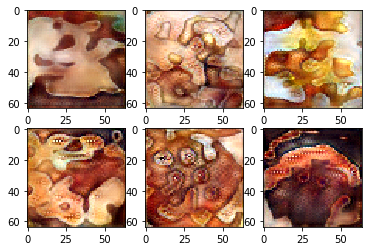

Save image: generadas/fig0.png
Save image: generadas/fig1.png
Save image: generadas/fig2.png
Save image: generadas/fig3.png
Save image: generadas/fig4.png
Save image: generadas/fig5.png
Save image: generadas/fig6.png
Save image: generadas/fig7.png
Save image: generadas/fig8.png
Save image: generadas/fig9.png
Save image: generadas/fig10.png
Save image: generadas/fig11.png
Save image: generadas/fig12.png
Save image: generadas/fig13.png
Save image: generadas/fig14.png
Save image: generadas/fig15.png
Save image: generadas/fig16.png
Save image: generadas/fig17.png
Save image: generadas/fig18.png
Save image: generadas/fig19.png
Save image: generadas/fig20.png
Save image: generadas/fig21.png
Save image: generadas/fig22.png
Save image: generadas/fig23.png
Save image: generadas/fig24.png
Save image: generadas/fig25.png
Save image: generadas/fig26.png
Save image: generadas/fig27.png
Save image: generadas/fig28.png
Save image: generadas/fig29.png
Save image: generadas/fig30.png
Save image: genera

In [15]:
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import os
model_dir = './models' #Directorio para guardar el modelo entrenado.
imagenes_generadas= "generadas" #Directorio para guardar las imágenes generadas.


init = tf.global_variables_initializer()
saver = tf.train.Saver()


batch_tam = 64 #tamaño del minibatch
iterations = 1 #Número de iteraciones
h = 64 #altura de las imágenes
w = 64 #anchura de las imágenes
n = 3 #número de canales de las imágenes
z_unidades = 100 #tamaño del vector de ruido z

    
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:   
    #Restaura variables desde disco
    print('Cargando el modelo ...')
    sess.run(init)
    ckpt = tf.train.get_checkpoint_state(model_dir)
    saver.restore(sess,ckpt.model_checkpoint_path)
    
    
    for i in range(iterations): 
        zs = sample_noise_batch(batch_tam, z_unidades) #Genera un mini batch para de z
        
        batch_X = sample_data_batch(X,batch_tam) #Obtiene un minibatch de imágenes

        #Actualiza D 2 veces
        for _ in range(2):
            _,d_costo_actual = sess.run([act_D,d_costo],feed_dict={z:zs , x:batch_X}) #Actualiza el discriminador
        
        
        #Actualiza  G
        _,g_costo_actual = sess.run([act_G,g_costo],feed_dict={z :zs})
        
        if i % 100 == 0:
            display.clear_output(wait=True) #Limpia las imágenes anteriores de la pantalla
            print("Iteración:", i)
            print("Costo generador: " + str(g_costo_actual) + " Costo discriminador: " + str(d_costo_actual))
            
            z2 = sample_noise_batch(batch_tam, z_unidades)#Genera de nuevo z para generara imágenes con G.
            generadas = sess.run(Gz,feed_dict={z:z2}) 
            show_images(generadas,2,3,(h,w,n), sharp=True)
            
            if not os.path.exists(imagenes_generadas):
                os.makedirs(imagenes_generadas)
            
            nombres= [imagenes_generadas+'/fig'+str(i + k) +'.png' for k in range(batch_tam)]
            save_batch_images(generadas,nombres)
            
        if i % 200 == 0 and i != 0:
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)
            path = model_dir+'/model-'+str(i)+'.cptk'
            saver.save(sess,path)
            print("Modelo guardado con nombre : %s" % path )
